# Preparación de los datos

In [27]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pickle
import copy
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from scipy.stats import uniform
from scipy.stats import randint as sp_randint

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

import warnings

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *


In [28]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Anio2017.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [29]:
# Se obtienen los datos de 2017
df_acoustics = pd.read_csv('data/raw/Anio2017.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


370

In [30]:
# Se les concatenan los datos del resto de años de los csv
for year in range(2018, 2024):
    path = 'data/raw/Anio' + str(year) + '.csv'
    df = pd.read_csv(path, encoding=result['encoding'], delimiter=';')
    df_acoustics = pd.concat([df_acoustics, df])

len(df_acoustics)


2292

In [31]:
# Se le concatenan, ahora, los datos del resto de años de los xls
# Se parte de 2012 porque en 2011 faltan 5 zonas
month_dict = {'ene': '01',
                'feb': '02',
                'mar': '03',
                'abr': '04',
                'may': '05',
                'jun': '06',
                'jul': '07',
                'ago': '08',
                'sep': '09',
                'oct': '10',
                'nov': '11',
                'dic': '12'
                }

skiprows = 3

for year in range(2012, 2017):
    path = 'data/raw/anio' + str(year) + '.xls'
    if year == 2015:
        month_dict_2015 = month_dict.copy()
        month_dict_2015.pop('jun')
        month_dict_2015.pop('jul')
        for sheet in range(10):
            df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
            df_xls['Fecha'] = list(month_dict_2015.keys())[sheet] + '-' + str(year)[2:]
            df_acoustics = pd.concat([df_acoustics, df_xls])
    else:
        if year == 2014:
            skiprows += 1
        for sheet in range(12):
            df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
            df_xls['Fecha'] = list(month_dict.keys())[sheet] + '-' + str(year)[2:]
            df_acoustics = pd.concat([df_acoustics, df_xls])

df_acoustics = df_acoustics.reset_index(drop=True)

len(df_acoustics)


C:\Users\Roger\AppData\Local\Temp\ipykernel_2744\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
C:\Users\Roger\AppData\Local\Temp\ipykernel_2744\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
C:\Users\Roger\AppData\Local\Temp\ipykernel_2744\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
C:\Users\Roger\AppData\Local\Temp\ipykernel_2744\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a Par

4193

In [32]:
# Se elimina la columna "Unnamed"
df_acoustics = df_acoustics.drop(columns='Unnamed: 3')

df_acoustics.head()


,Fecha,NMT,Situación,Ld,Le,Ln,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99,Nombre,LAeq,L1,L10,L50,L90,L99
0,ene-17,1,Paseo de Recoletos,"69,1","69,2","66,5","68,2",74,"71,3","65,8","57,9",50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ene-17,2,Carlos V,"70,2","69,8","66,9","69,3","75,5","71,4","67,9","61,2","54,8",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ene-17,3,Plaza del Carmen,"67,7","60,9","62,8","65,8","75,4",66,"58,5","53,4","50,7",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ene-17,4,Plaza de España,"65,9","65,9","62,4",65,"72,7","67,4","63,5","56,4","49,1",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ene-17,5,Barrio del Pilar,"65,7","66,2","60,1","64,6","74,4",67,"59,7","46,9","37,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Se fusionan las columnas "Nombre" y "Situación", que son la misma cosa
df_acoustics['Situación'] = df_acoustics['Situación'].fillna(df_acoustics['Nombre'])
df_acoustics = df_acoustics.drop(columns='Nombre')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   Ld         2912 non-null   object
 4   Le         2912 non-null   object
 5   Ln         2912 non-null   object
 6   LAeq24     3344 non-null   object
 7   LAS01      3342 non-null   object
 8   LAS10      3342 non-null   object
 9   LAS50      3342 non-null   object
 10  LAS90      3342 non-null   object
 11  LAS99      3342 non-null   object
 12  LAeq       728 non-null    object
 13  L1         728 non-null    object
 14  L10        728 non-null    object
 15  L50        728 non-null    object
 16  L90        728 non-null    object
 17  L99        728 non-null    object
dtypes: object(18)
memory usage: 589.8+ KB


In [34]:
# Se fusionan las demás columnas con datos comunes
for tuple in [('LAeq24', 'LAeq'), ('LAS01', 'L1'), ('LAS10', 'L10'), ('LAS50', 'L50'), ('LAS90', 'L90'), ('LAS99', 'L99')]:
    df_acoustics[tuple[0]] = df_acoustics[tuple[0]].fillna(df_acoustics[tuple[1]])

df_acoustics = df_acoustics.drop(columns=['LAeq', 'L1', 'L10', 'L50', 'L90', 'L99'])

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   Ld         2912 non-null   object
 4   Le         2912 non-null   object
 5   Ln         2912 non-null   object
 6   LAeq24     4072 non-null   object
 7   LAS01      4070 non-null   object
 8   LAS10      4070 non-null   object
 9   LAS50      4070 non-null   object
 10  LAS90      4070 non-null   object
 11  LAS99      4070 non-null   object
dtypes: object(12)
memory usage: 393.2+ KB


In [35]:
# Se borran las columnas con datos de mañana, día y noche, pues no existen para todos los años
df_acoustics = df_acoustics.drop(columns=['Ld', 'Le', 'Ln'])

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4070 non-null   object
 5   LAS10      4070 non-null   object
 6   LAS50      4070 non-null   object
 7   LAS90      4070 non-null   object
 8   LAS99      4070 non-null   object
dtypes: object(9)
memory usage: 294.9+ KB


In [36]:
# Se buscan los valores donde las "LAS" son nulos pero "LAeq" no
df_acoustics[df_acoustics['LAS50'].isna() & df_acoustics['Situación'].notna()]


,Fecha,NMT,Situación,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99
4143,nov-16,16,Arturo Soria,61.5,NaN,NaN,NaN,NaN,NaN
4147,nov-16,20,Avda de Moratalaz,62.1,NaN,NaN,NaN,NaN,NaN


In [37]:
# Se busca el mes anterior a ese punto
df_acoustics[((df_acoustics['Situación'] == 'Arturo Soria') | (df_acoustics['Situación'] == 'Avda de Moratalaz'))
                & (df_acoustics['Fecha'] == 'oct-16')
              ]


,Fecha,NMT,Situación,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99
4112,oct-16,16,Arturo Soria,60.8,67.8,64.5,58.6,42.7,37.1
4116,oct-16,20,Avda de Moratalaz,61.6,70.8,64.2,58.0,44.8,36.1


In [38]:
# Se imputan esos nulos al mes anterior
for col, values in [('LAS01', [67.8, 70.8]), ('LAS10', [64.5, 64.2]), ('LAS50', [58.6, 58.0]), ('LAS90', [42.7, 44.8]), ('LAS99', [37.1, 36.1])]:
    fill_dict =  {4143: values[0], 4147: values[1]}
    df_acoustics[col] = df_acoustics[col].fillna(value=fill_dict)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4072 non-null   object
 5   LAS10      4072 non-null   object
 6   LAS50      4072 non-null   object
 7   LAS90      4072 non-null   object
 8   LAS99      4072 non-null   object
dtypes: object(9)
memory usage: 294.9+ KB


In [39]:
# Se borran los demás nulos, pues son errores de la conversion de los xls
# Todavía existen nulos, pero no son fallos de conversión y están en formato "string"
df_acoustics = df_acoustics.dropna()

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4072 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4072 non-null   object
 1   NMT        4072 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4072 non-null   object
 5   LAS10      4072 non-null   object
 6   LAS50      4072 non-null   object
 7   LAS90      4072 non-null   object
 8   LAS99      4072 non-null   object
dtypes: object(9)
memory usage: 318.1+ KB


In [40]:
# Se añaden los meses faltantes del año 15 con nulos. Se imputarán más adelante
for month in ['jun-15', 'jul-15']:
    df_summer_15 = df_acoustics[df_acoustics['Fecha'] == 'ago-15'].copy()
    df_summer_15[['LAeq24', 'LAS01', 'LAS10', 'LAS50', 'LAS90', 'LAS99', 'NMT']] = np.nan
    df_summer_15['Fecha'] = month
    df_acoustics = pd.concat([df_acoustics, df_summer_15])


In [41]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['Fecha'] = df_acoustics['Fecha'].str.split('-').apply(lambda x: f'{month_dict[x[0]]}-{x[1]}')
df_acoustics['Fecha'] = pd.to_datetime(df_acoustics['Fecha'], format='%m-%y')

df_acoustics = df_acoustics.rename(columns={'Fecha': 'mes'})

df_acoustics = df_acoustics.set_index('mes')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01',
               ...
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01'],
              dtype='datetime64[ns]', name='mes', length=4134, freq=None)

In [42]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics = df_acoustics.astype(str)

for col in df_acoustics.columns[2:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = df_acoustics[col].apply(lambda x: float(x) if x != 'N/D' else np.nan)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4134 entries, 2012-01-01 to 2023-02-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NMT        4134 non-null   object 
 1   Situación  4134 non-null   object 
 2   LAeq24     4019 non-null   float64
 3   LAS01      4005 non-null   float64
 4   LAS10      4005 non-null   float64
 5   LAS50      4005 non-null   float64
 6   LAS90      4005 non-null   float64
 7   LAS99      4005 non-null   float64
dtypes: float64(6), object(2)
memory usage: 290.7+ KB


In [43]:
# Se cambian los nombres de las columnas para mayor claridad
df_acoustics = df_acoustics.rename(columns={'NMT': 'num_medidas',
                                          'Situación': 'zonas',
                                            'LAeq24': 'sonido_24_h',
                                            'LAS01': 'sonido_superado_1%',
                                            'LAS10': 'sonido_superado_10%',
                                            'LAS50': 'sonido_superado_50%',
                                            'LAS90': 'sonido_superado_90%',
                                            'LAS99': 'sonido_superado_99%'
                                            }
                                    )                   

df_acoustics.head()


,num_medidas,zonas,sonido_24_h,sonido_superado_1%,sonido_superado_10%,sonido_superado_50%,sonido_superado_90%,sonido_superado_99%
mes,,,,,,,,
2012-01-01,1,Paseo de Recoletos,68.7,74.9,72.0,66.5,59.1,51.0
2012-01-01,86,Tres Olivos,58.1,66.9,61.2,52.0,39.3,36.6
2012-01-01,55,Urbanización Embajada II,55.9,63.5,58.1,51.1,44.3,41.3
2012-01-01,50,Pza de Castilla,66.8,72.8,68.4,64.9,58.3,50.8
2012-01-01,48,Castellana,63.9,69.3,66.5,62.5,54.8,46.1


In [44]:
# Se pivota la tabla para que cada columna sea una zona y los valores sean el valor que supera los que hay el 50% del tiempo 
# Así podemos decir que la mayoría del tiempo se supera tal o cual valor
df_acoustics = df_acoustics.pivot_table(index='mes', columns='zonas', values='sonido_superado_50%')

df_acoustics.head()


zonas,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.9,59.7,59.1,54.5,59.9,57.5,NaN,46.5,62.5,60.9,...,64.9,58.1,64.9,66.5,55.1,NaN,52.0,51.1,53.8,52.2
2012-02-01,57.6,59.4,58.8,54.6,59.4,58.0,NaN,47.5,62.2,61.6,...,64.2,57.8,64.6,66.5,54.5,NaN,51.8,51.2,54.2,52.2
2012-03-01,57.5,59.0,58.3,53.7,59.1,57.4,NaN,48.2,62.1,60.8,...,64.1,58.5,64.1,66.0,53.2,NaN,51.9,50.3,53.7,52.6
2012-04-01,57.7,59.0,58.5,53.1,58.7,56.6,NaN,46.6,62.1,60.3,...,63.8,58.6,64.5,65.7,54.0,NaN,52.6,50.4,53.4,52.9
2012-05-01,57.2,58.4,58.1,53.5,59.3,57.1,NaN,46.8,61.5,60.6,...,63.9,59.5,63.9,65.7,53.2,NaN,52.9,50.6,54.0,54.3


In [45]:
# Plaza de España tiene muchos nulos
df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2012-01-01 to 2023-02-01
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          131 non-null    float64
 1   Arturo Soria              130 non-null    float64
 2   Avda de Moratalaz         132 non-null    float64
 3   Barajas Pueblo            132 non-null    float64
 4   Barrio del Pilar          132 non-null    float64
 5   Campo de las Naciones     132 non-null    float64
 6   Carlos V                  125 non-null    float64
 7   Casa de Campo             132 non-null    float64
 8   Castellana                131 non-null    float64
 9   Cuatro Caminos            131 non-null    float64
 10  Cuatro Vientos            132 non-null    float64
 11  El Pardo                  132 non-null    float64
 12  Embajada                  130 non-null    float64
 13  Ensanche de Vallecas      126 non-null    floa

In [46]:
# Se establece la frecuencia "MS" ("month start") y se interpolan los nulos
df_acoustics = df_acoustics.asfreq('MS')

df_acoustics = df_acoustics.apply(lambda x: x.interpolate(method='linear'))

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  129 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

In [47]:
# Hay algunos valores que se resisten a ser imputados por ser los primeros. Se atribuyen al más cercano
df_acoustics.loc[df_acoustics['Carlos V'].isna(), 'Carlos V'] = 67.8
df_acoustics.loc[df_acoustics['Gregorio Marañón'].isna(), 'Gregorio Marañón'] = 66.0
df_acoustics.loc[df_acoustics['Santa Eugenia'].isna(), 'Santa Eugenia'] = 61.8

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  134 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

# ML

## Preparación

In [49]:
# Se crea un dataframe donde el índice es cada zona
new_df = pd.DataFrame(index=df_acoustics.columns, columns=df_acoustics.index)

for col in df_acoustics.columns:
    for row in df_acoustics.index:
        new_df.loc[col, row] = df_acoustics.loc[row, col]

new_df.head()


mes,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,...,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
zonas,,,,,,,,,,,,,,,,,,,,,
Alto Extremadura,57.9,57.6,57.5,57.7,57.2,57.1,56.4,55.1,56.6,57.2,...,55.0,55.0,53.4,51.9,54.0,54.0,55.2,55.3,55.0,54.4
Arturo Soria,59.7,59.4,59.0,59.0,58.4,58.2,57.4,56.0,58.4,59.2,...,51.9,52.4,52.966667,53.533333,54.1,54.5,56.0,56.3,55.1,54.7
Avda de Moratalaz,59.1,58.8,58.3,58.5,58.1,58.5,56.6,55.1,57.6,58.6,...,56.3,55.8,54.6,53.8,55.2,55.7,56.1,56.2,55.8,55.5
Barajas Pueblo,54.5,54.6,53.7,53.1,53.5,53.5,53.0,51.8,53.1,53.0,...,53.4,52.5,52.6,51.4,53.0,53.3,53.7,52.7,54.3,53.7
Barrio del Pilar,59.9,59.4,59.1,58.7,59.3,59.6,59.6,58.6,59.4,60.4,...,56.8,57.1,56.7,56.3,57.3,58.4,57.7,57.8,57.6,57.6


In [50]:
# Se pasan los valores a "float"
new_df = new_df.astype(float)

new_df.head()


mes,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,...,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
zonas,,,,,,,,,,,,,,,,,,,,,
Alto Extremadura,57.9,57.6,57.5,57.7,57.2,57.1,56.4,55.1,56.6,57.2,...,55.0,55.0,53.400000,51.900000,54.0,54.0,55.2,55.3,55.0,54.4
Arturo Soria,59.7,59.4,59.0,59.0,58.4,58.2,57.4,56.0,58.4,59.2,...,51.9,52.4,52.966667,53.533333,54.1,54.5,56.0,56.3,55.1,54.7
Avda de Moratalaz,59.1,58.8,58.3,58.5,58.1,58.5,56.6,55.1,57.6,58.6,...,56.3,55.8,54.600000,53.800000,55.2,55.7,56.1,56.2,55.8,55.5
Barajas Pueblo,54.5,54.6,53.7,53.1,53.5,53.5,53.0,51.8,53.1,53.0,...,53.4,52.5,52.600000,51.400000,53.0,53.3,53.7,52.7,54.3,53.7
Barrio del Pilar,59.9,59.4,59.1,58.7,59.3,59.6,59.6,58.6,59.4,60.4,...,56.8,57.1,56.700000,56.300000,57.3,58.4,57.7,57.8,57.6,57.6


## Baseline

### Target: 2023

In [51]:
# Se establecen los modelos que se quieren probar
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': ''}

In [62]:
# Se eligen las fechas del 2022 y 2023 para test
cols_2023 = new_df.columns[-14:]

In [63]:
# Se lanza el "baseline"
baseline = Regression(new_df, cols_2023)
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.12 sec(s). Total time: 0.12
Starting Ridge:
- Ridge done in 0.12 sec(s). Total time: 0.24
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.36 sec(s). Total time: 0.6
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.1 sec(s). Total time: 0.7
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 1.81 sec(s). Total time: 2.5
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 2.46 sec(s). Total time: 4.97


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,1.224604,1.180895,2.228678,2.348823,1.776447,2.068848,Ridge,DecisionTreeRegressor: random_state=43
mse,1.805640,1.667852,5.481505,6.121888,3.718281,5.043614,Ridge,DecisionTreeRegressor: random_state=43
mae,0.991281,0.960384,1.959538,2.018549,1.491326,1.757723,Ridge,DecisionTreeRegressor: random_state=43
r2_score,0.914999,0.921134,0.718811,0.717314,0.792710,0.702368,Ridge,XGBRegressor: random_state=43
mape,0.017358,0.016830,0.034367,0.035762,0.026170,0.030630,Ridge,DecisionTreeRegressor: random_state=43


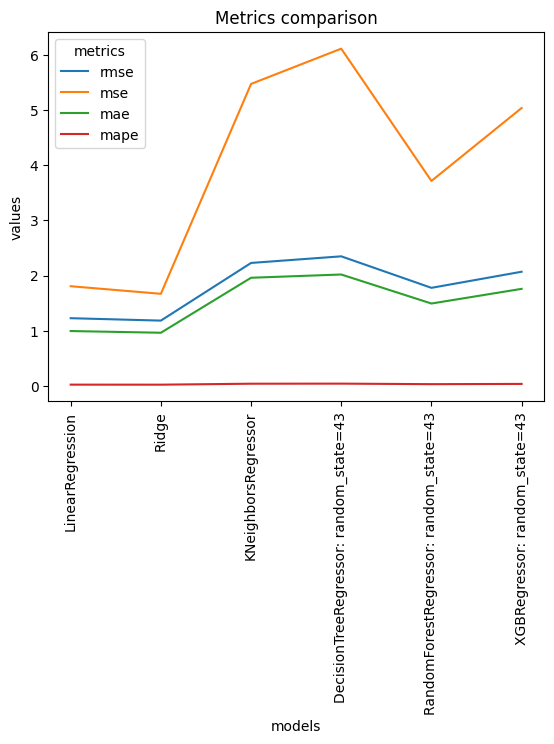

In [64]:
# Se visualizan los resultados. Ridge es el mejor, ya que la relación es lineal y las variables están bastante correlacionadas
baseline.visualize('rmse', 'mse', 'mae', 'mape')

### Target: una sola fecha

In [65]:
Regression.add_models('SVR')

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': '',
 'SVR': ''}

In [67]:
# Se lanza el "baseline"
baseline = Regression(new_df, '2023-02-01')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43'],
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.07 sec(s). Total time: 0.07
Starting Ridge:
- Ridge done in 0.06 sec(s). Total time: 0.14
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.09 sec(s). Total time: 0.22
Starting SVR:
- SVR done in 0.11 sec(s). Total time: 0.34
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.17 sec(s). Total time: 0.5
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 1.64 sec(s). Total time: 2.14
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 0.76 sec(s). Total time: 2.9


,LinearRegression,Ridge,KNeighborsRegressor,SVR,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,0.855811,0.845380,2.218546,3.592319,2.405219,1.717409,1.833017,Ridge,SVR
mse,0.781743,0.767372,5.153640,13.239192,6.007500,3.379645,4.178645,Ridge,SVR
mae,0.713506,0.710009,1.828400,2.706504,2.127000,1.421720,1.472164,Ridge,SVR
r2_score,0.971142,0.971718,0.795765,0.454183,0.765280,0.865139,0.831798,Ridge,XGBRegressor: random_state=43
mape,0.012375,0.012329,0.031833,0.047794,0.037109,0.024854,0.025444,Ridge,SVR


## Modelaje

### Prueba

In [146]:
# Se hace la predicción de las fechas de 2022 y 2023
df_to_train = new_df.copy()

df_to_train = df_to_train.drop(columns=cols_2023)

df_test = new_df[cols_2023]

df_to_train.head()


mes,2012-01-01,2012-02-01,2012-03-01,2012-04-01,2012-05-01,2012-06-01,2012-07-01,2012-08-01,2012-09-01,2012-10-01,...,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01
zonas,,,,,,,,,,,,,,,,,,,,,
Alto Extremadura,57.9,57.6,57.5,57.7,57.2,57.1,56.4,55.1,56.6,57.2,...,54.5,54.9,54.3,54.6,54.1,52.8,54.6,55.0,55.6,55.5
Arturo Soria,59.7,59.4,59.0,59.0,58.4,58.2,57.4,56.0,58.4,59.2,...,57.1,57.3,56.7,57.1,55.8,54.4,52.0,52.4,53.4,53.2
Avda de Moratalaz,59.1,58.8,58.3,58.5,58.1,58.5,56.6,55.1,57.6,58.6,...,55.5,56.3,56.3,56.0,55.2,53.9,55.6,56.0,56.1,55.9
Barajas Pueblo,54.5,54.6,53.7,53.1,53.5,53.5,53.0,51.8,53.1,53.0,...,50.3,50.1,50.6,51.5,51.4,51.7,52.4,52.0,53.8,52.4
Barrio del Pilar,59.9,59.4,59.1,58.7,59.3,59.6,59.6,58.6,59.4,60.4,...,57.5,57.0,56.7,57.4,57.0,55.9,57.3,57.2,57.1,57.4


In [147]:
for _ in range(14):
    last_column = str(df_to_train.columns[-1]).split()[0]
    X = df_to_train.drop(columns=last_column)
    y = df_to_train[last_column]
    
    model = XGBRegressor()
    model.fit(X, y)

    first_column = str(df_to_train.columns[0]).split()[0]
    df_to_train = df_to_train.drop(columns=first_column)
    pred = model.predict(df_to_train.values)

    new_date = datetime.strptime(last_column, '%Y-%m-%d')
    new_date = new_date + relativedelta(months=1)

    df_to_train[str(new_date).split()[0]] = pred

df_to_train.head()


mes,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,...,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01
zonas,,,,,,,,,,,,,,,,,,,,,
Alto Extremadura,57.8,57.7,57.2,56.6,56.2,55.2,56.7,57.2,57.3,57.9,...,56.814377,56.810318,56.534210,56.532669,56.532692,56.525684,56.525192,56.416801,56.399239,56.404549
Arturo Soria,59.9,59.4,58.6,58.0,57.7,55.6,58.1,59.3,59.3,60.0,...,54.683975,54.656067,54.691292,55.113327,56.233391,56.320381,56.394852,60.685642,60.674911,56.367344
Avda de Moratalaz,58.1,58.2,57.3,57.1,56.5,54.5,57.0,58.0,58.2,58.7,...,56.813908,56.815472,56.538742,56.539841,56.518642,56.526684,56.523121,56.415279,56.479599,56.481342
Barajas Pueblo,52.3,53.7,53.3,53.3,54.2,52.0,52.9,52.6,53.8,53.6,...,54.156055,53.806664,50.970394,53.717258,53.624546,54.762623,52.589405,52.073978,56.013699,52.305820
Barrio del Pilar,59.1,59.2,58.2,59.0,58.6,57.3,58.6,59.7,58.9,59.0,...,56.916809,56.970711,56.932083,56.932472,60.781322,56.518600,56.526787,56.524231,56.488213,56.491119


In [148]:
pred = df_to_train[df_to_train.index == 'Alto Extremadura']
test = df_test[df_test.index == 'Alto Extremadura']


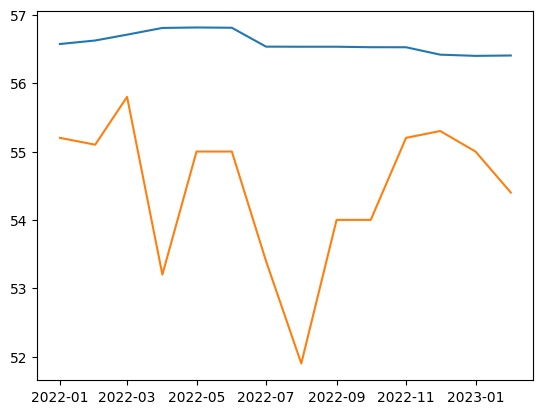

In [150]:
plt.plot(pred[cols_2023].T)
plt.plot(test[cols_2023].T)


In [152]:
print(f'rmse: {mean_squared_error(test[cols_2023].values[0], pred[cols_2023].values[0], squared=False)}')
print(f'mse: {mean_squared_error(test[cols_2023].values[0], pred[cols_2023].values[0])}')
print(f'mae: {mean_absolute_error(test[cols_2023].values[0], pred[cols_2023].values[0])}')
print(f'r2: {r2_score(test[cols_2023].values[0], pred[cols_2023].values[0])}')
print(f'mape: {mean_absolute_percentage_error(test[cols_2023].values[0], pred[cols_2023].values[0])}')


rmse: 2.355464338746016
mse: 5.548212251104206
mae: 2.1220874786376953
r2: -4.330374007237021
mape: 0.039332531302163486
